In [11]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

In [12]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025])

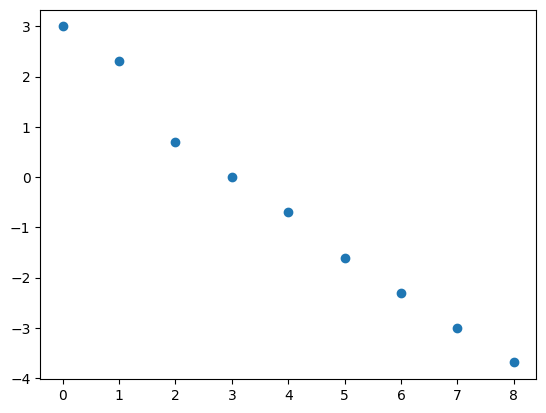

In [46]:
plt.scatter(range(9),np.log(rs))

In [13]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [14]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [15]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [47]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
for r_idx in range(9):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:] * prob_2d
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

20.0 0
10.0 0
2.0 1
1.0 1
0.5 1
0.2 2
0.1 2
0.05 3
0.025 3


In [63]:
from torch.utils.data import random_split
train_data, test_data = random_split(dataset, [int(2700*0.8), int(2700*0.2)])

In [64]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        # self.conv1 = GCNConv(num_node_features, 64)     
        # self.conv2 = GCNConv(64, 32) 
        # self.conv3 = GCNConv(32, 16) 
        # self.conv4 = GCNConv(16, 8) 
        # self.classifier = Linear(8, num_classes)
        self.classifier = Linear(num_node_features, num_classes)

    """
        hyperparameters:
        - number of hidden layers
        - number of hidden channels
        - dropout rate (now it's zero)
        - learning rate <- most important to tune
        - weight decay
        - etc etc.
    """

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
        edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))

        # x = self.conv1(x, edge_index, edge_weight)
        # x = F.relu(x)

        # x = self.conv2(x, edge_index, edge_weight)
        # x = F.relu(x)

        # x = self.conv3(x, edge_index, edge_weight)
        # x = F.relu(x)
        
        # x = self.conv4(x, edge_index, edge_weight)
        # x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = self.classifier(x)

        # x = F.relu(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50, num_classes=1).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
#         loss = F.cross_entropy(output, label)
        loss = F.mse_loss(output, label) 
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        optimizer.step() 
        
        results.append(output)
        
        _, predicted = torch.max(output, 1)  
#         total += label.size(0)  
#         correct += (predicted == label).sum().item()  
#     accuracy = 100 * correct / total
    return loss_all / len(myloader.dataset), results, y_true

loss_ep = []
ac_ep = []


from tqdm import tqdm 

counter = 0
count_epochs = 0
best = float("inf")
epochs = 100
patience = 5
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
#     ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 001, Loss: 5.5757:   1%|          | 1/100 [00:00<01:00,  1.63it/s]

Epoch: 001, Loss: 5.57565


Epoch: 002, Loss: 4.8727:   2%|▏         | 2/100 [00:01<00:58,  1.68it/s]

Epoch: 002, Loss: 4.87271


Epoch: 003, Loss: 4.7472:   3%|▎         | 3/100 [00:01<00:56,  1.73it/s]

Epoch: 003, Loss: 4.74717


Epoch: 004, Loss: 4.6821:   4%|▍         | 4/100 [00:02<00:55,  1.73it/s]

Epoch: 004, Loss: 4.68214


Epoch: 005, Loss: 4.6677:   5%|▌         | 5/100 [00:02<00:54,  1.75it/s]

Epoch: 005, Loss: 4.66773


Epoch: 006, Loss: 4.6051:   6%|▌         | 6/100 [00:03<00:54,  1.74it/s]

Epoch: 006, Loss: 4.60514


Epoch: 007, Loss: 4.4790:   7%|▋         | 7/100 [00:04<00:55,  1.69it/s]

Epoch: 007, Loss: 4.47899


Epoch: 008, Loss: 4.4237:   8%|▊         | 8/100 [00:04<00:55,  1.66it/s]

Epoch: 008, Loss: 4.42369


Epoch: 009, Loss: 4.3518:   9%|▉         | 9/100 [00:05<00:53,  1.69it/s]

Epoch: 009, Loss: 4.35181


Epoch: 010, Loss: 4.2784:  10%|█         | 10/100 [00:05<00:52,  1.72it/s]

Epoch: 010, Loss: 4.27843


Epoch: 011, Loss: 4.2406:  11%|█         | 11/100 [00:06<00:50,  1.75it/s]

Epoch: 011, Loss: 4.24059


Epoch: 012, Loss: 4.1817:  12%|█▏        | 12/100 [00:06<00:50,  1.75it/s]

Epoch: 012, Loss: 4.18173


Epoch: 013, Loss: 4.1077:  13%|█▎        | 13/100 [00:07<00:50,  1.74it/s]

Epoch: 013, Loss: 4.10767


Epoch: 014, Loss: 4.0360:  14%|█▍        | 14/100 [00:08<00:49,  1.74it/s]

Epoch: 014, Loss: 4.03604


Epoch: 015, Loss: 3.9693:  15%|█▌        | 15/100 [00:08<00:48,  1.74it/s]

Epoch: 015, Loss: 3.96930


Epoch: 016, Loss: 3.9518:  16%|█▌        | 16/100 [00:09<00:48,  1.72it/s]

Epoch: 016, Loss: 3.95175


Epoch: 017, Loss: 3.8775:  17%|█▋        | 17/100 [00:09<00:48,  1.72it/s]

Epoch: 017, Loss: 3.87753


Epoch: 018, Loss: 3.8547:  18%|█▊        | 18/100 [00:10<00:47,  1.74it/s]

Epoch: 018, Loss: 3.85474


Epoch: 019, Loss: 3.7555:  19%|█▉        | 19/100 [00:11<00:47,  1.72it/s]

Epoch: 019, Loss: 3.75553


Epoch: 020, Loss: 3.7034:  20%|██        | 20/100 [00:11<00:46,  1.73it/s]

Epoch: 020, Loss: 3.70339


Epoch: 021, Loss: 3.6428:  21%|██        | 21/100 [00:12<00:45,  1.73it/s]

Epoch: 021, Loss: 3.64282


Epoch: 022, Loss: 3.6025:  22%|██▏       | 22/100 [00:12<00:44,  1.75it/s]

Epoch: 022, Loss: 3.60245


Epoch: 023, Loss: 3.5846:  23%|██▎       | 23/100 [00:13<00:44,  1.75it/s]

Epoch: 023, Loss: 3.58457


Epoch: 024, Loss: 3.5000:  24%|██▍       | 24/100 [00:13<00:44,  1.72it/s]

Epoch: 024, Loss: 3.49998


Epoch: 025, Loss: 3.4810:  25%|██▌       | 25/100 [00:14<00:43,  1.72it/s]

Epoch: 025, Loss: 3.48101


Epoch: 026, Loss: 3.4055:  26%|██▌       | 26/100 [00:15<00:42,  1.73it/s]

Epoch: 026, Loss: 3.40548


Epoch: 027, Loss: 3.3703:  27%|██▋       | 27/100 [00:15<00:41,  1.74it/s]

Epoch: 027, Loss: 3.37035


Epoch: 028, Loss: 3.3858:  28%|██▊       | 28/100 [00:16<00:41,  1.75it/s]

Epoch: 028, Loss: 3.38579


Epoch: 029, Loss: 3.2891:  29%|██▉       | 29/100 [00:16<00:41,  1.70it/s]

Epoch: 029, Loss: 3.28905


Epoch: 030, Loss: 3.3242:  30%|███       | 30/100 [00:17<00:40,  1.71it/s]

Epoch: 030, Loss: 3.32415


Epoch: 031, Loss: 3.2584:  31%|███       | 31/100 [00:17<00:40,  1.72it/s]

Epoch: 031, Loss: 3.25840


Epoch: 032, Loss: 3.2000:  32%|███▏      | 32/100 [00:18<00:39,  1.74it/s]

Epoch: 032, Loss: 3.19999


Epoch: 033, Loss: 3.1412:  33%|███▎      | 33/100 [00:19<00:38,  1.75it/s]

Epoch: 033, Loss: 3.14119


Epoch: 034, Loss: 3.1225:  34%|███▍      | 34/100 [00:19<00:38,  1.73it/s]

Epoch: 034, Loss: 3.12253


Epoch: 035, Loss: 3.1749:  35%|███▌      | 35/100 [00:20<00:37,  1.74it/s]

Epoch: 035, Loss: 3.17494


Epoch: 036, Loss: 3.1470:  36%|███▌      | 36/100 [00:20<00:36,  1.74it/s]

Epoch: 036, Loss: 3.14699


Epoch: 037, Loss: 3.1542:  37%|███▋      | 37/100 [00:21<00:36,  1.73it/s]

Epoch: 037, Loss: 3.15419


Epoch: 038, Loss: 3.0372:  38%|███▊      | 38/100 [00:21<00:35,  1.73it/s]

Epoch: 038, Loss: 3.03720


Epoch: 039, Loss: 2.9816:  39%|███▉      | 39/100 [00:22<00:35,  1.73it/s]

Epoch: 039, Loss: 2.98157


Epoch: 040, Loss: 2.9677:  40%|████      | 40/100 [00:23<00:34,  1.71it/s]

Epoch: 040, Loss: 2.96768


Epoch: 041, Loss: 2.9377:  41%|████      | 41/100 [00:23<00:34,  1.71it/s]

Epoch: 041, Loss: 2.93769


Epoch: 042, Loss: 2.9579:  42%|████▏     | 42/100 [00:24<00:33,  1.71it/s]

Epoch: 042, Loss: 2.95788


Epoch: 043, Loss: 2.8812:  43%|████▎     | 43/100 [00:24<00:33,  1.71it/s]

Epoch: 043, Loss: 2.88115


Epoch: 044, Loss: 2.8673:  44%|████▍     | 44/100 [00:25<00:32,  1.70it/s]

Epoch: 044, Loss: 2.86731


Epoch: 045, Loss: 2.8426:  45%|████▌     | 45/100 [00:26<00:32,  1.72it/s]

Epoch: 045, Loss: 2.84262


Epoch: 046, Loss: 2.8273:  46%|████▌     | 46/100 [00:26<00:31,  1.73it/s]

Epoch: 046, Loss: 2.82728


Epoch: 047, Loss: 2.8287:  47%|████▋     | 47/100 [00:27<00:30,  1.71it/s]

Epoch: 047, Loss: 2.82868


Epoch: 048, Loss: 2.8958:  48%|████▊     | 48/100 [00:27<00:30,  1.71it/s]

Epoch: 048, Loss: 2.89581


Epoch: 049, Loss: 2.8680:  49%|████▉     | 49/100 [00:28<00:29,  1.73it/s]

Epoch: 049, Loss: 2.86796


Epoch: 050, Loss: 2.7389:  50%|█████     | 50/100 [00:29<00:29,  1.70it/s]

Epoch: 050, Loss: 2.73893


Epoch: 051, Loss: 2.7327:  51%|█████     | 51/100 [00:29<00:28,  1.71it/s]

Epoch: 051, Loss: 2.73272


Epoch: 052, Loss: 2.7590:  52%|█████▏    | 52/100 [00:30<00:27,  1.72it/s]

Epoch: 052, Loss: 2.75900


Epoch: 053, Loss: 2.6730:  53%|█████▎    | 53/100 [00:30<00:27,  1.73it/s]

Epoch: 053, Loss: 2.67296


Epoch: 054, Loss: 2.7038:  54%|█████▍    | 54/100 [00:31<00:26,  1.73it/s]

Epoch: 054, Loss: 2.70384


Epoch: 055, Loss: 2.6799:  55%|█████▌    | 55/100 [00:31<00:25,  1.73it/s]

Epoch: 055, Loss: 2.67994


Epoch: 056, Loss: 2.6669:  56%|█████▌    | 56/100 [00:32<00:25,  1.74it/s]

Epoch: 056, Loss: 2.66687


Epoch: 057, Loss: 2.6987:  57%|█████▋    | 57/100 [00:33<00:24,  1.73it/s]

Epoch: 057, Loss: 2.69874


Epoch: 058, Loss: 2.6357:  58%|█████▊    | 58/100 [00:33<00:24,  1.73it/s]

Epoch: 058, Loss: 2.63569


Epoch: 059, Loss: 2.6157:  59%|█████▉    | 59/100 [00:34<00:23,  1.75it/s]

Epoch: 059, Loss: 2.61571


Epoch: 060, Loss: 2.7371:  60%|██████    | 60/100 [00:34<00:22,  1.74it/s]

Epoch: 060, Loss: 2.73712


Epoch: 061, Loss: 2.7149:  61%|██████    | 61/100 [00:35<00:22,  1.73it/s]

Epoch: 061, Loss: 2.71488


Epoch: 062, Loss: 2.7214:  62%|██████▏   | 62/100 [00:35<00:21,  1.74it/s]

Epoch: 062, Loss: 2.72142


Epoch: 063, Loss: 2.6053:  63%|██████▎   | 63/100 [00:36<00:21,  1.73it/s]

Epoch: 063, Loss: 2.60533


Epoch: 064, Loss: 2.5806:  64%|██████▍   | 64/100 [00:37<00:21,  1.70it/s]

Epoch: 064, Loss: 2.58059


Epoch: 065, Loss: 2.5523:  65%|██████▌   | 65/100 [00:37<00:20,  1.70it/s]

Epoch: 065, Loss: 2.55231


Epoch: 066, Loss: 2.5300:  66%|██████▌   | 66/100 [00:38<00:19,  1.70it/s]

Epoch: 066, Loss: 2.53002


Epoch: 067, Loss: 2.5574:  67%|██████▋   | 67/100 [00:38<00:19,  1.72it/s]

Epoch: 067, Loss: 2.55740


Epoch: 068, Loss: 2.6601:  68%|██████▊   | 68/100 [00:39<00:18,  1.72it/s]

Epoch: 068, Loss: 2.66008


Epoch: 069, Loss: 2.5028:  69%|██████▉   | 69/100 [00:40<00:17,  1.73it/s]

Epoch: 069, Loss: 2.50282


Epoch: 070, Loss: 2.5727:  70%|███████   | 70/100 [00:40<00:17,  1.72it/s]

Epoch: 070, Loss: 2.57266


Epoch: 071, Loss: 2.5478:  71%|███████   | 71/100 [00:41<00:16,  1.73it/s]

Epoch: 071, Loss: 2.54775


Epoch: 072, Loss: 2.5347:  72%|███████▏  | 72/100 [00:41<00:16,  1.72it/s]

Epoch: 072, Loss: 2.53468


Epoch: 073, Loss: 2.4822:  73%|███████▎  | 73/100 [00:42<00:15,  1.73it/s]

Epoch: 073, Loss: 2.48221


Epoch: 074, Loss: 2.5276:  74%|███████▍  | 74/100 [00:42<00:15,  1.70it/s]

Epoch: 074, Loss: 2.52761


Epoch: 075, Loss: 2.5113:  75%|███████▌  | 75/100 [00:43<00:14,  1.70it/s]

Epoch: 075, Loss: 2.51132


Epoch: 076, Loss: 2.5029:  76%|███████▌  | 76/100 [00:44<00:14,  1.71it/s]

Epoch: 076, Loss: 2.50292


Epoch: 077, Loss: 2.4875:  77%|███████▋  | 77/100 [00:44<00:13,  1.72it/s]

Epoch: 077, Loss: 2.48748


Epoch: 078, Loss: 2.4531:  78%|███████▊  | 78/100 [00:45<00:12,  1.74it/s]

Epoch: 078, Loss: 2.45312


Epoch: 079, Loss: 2.4418:  79%|███████▉  | 79/100 [00:45<00:12,  1.70it/s]

Epoch: 079, Loss: 2.44184


Epoch: 080, Loss: 2.4579:  80%|████████  | 80/100 [00:46<00:11,  1.71it/s]

Epoch: 080, Loss: 2.45793


Epoch: 081, Loss: 2.4764:  81%|████████  | 81/100 [00:47<00:11,  1.73it/s]

Epoch: 081, Loss: 2.47639


Epoch: 082, Loss: 2.5785:  82%|████████▏ | 82/100 [00:47<00:10,  1.73it/s]

Epoch: 082, Loss: 2.57854


Epoch: 083, Loss: 2.4652:  83%|████████▎ | 83/100 [00:48<00:09,  1.74it/s]

Epoch: 083, Loss: 2.46519


Epoch: 084, Loss: 2.4298:  84%|████████▍ | 84/100 [00:48<00:09,  1.74it/s]

Epoch: 084, Loss: 2.42981


Epoch: 085, Loss: 2.4194:  85%|████████▌ | 85/100 [00:49<00:08,  1.73it/s]

Epoch: 085, Loss: 2.41942


Epoch: 086, Loss: 2.4007:  86%|████████▌ | 86/100 [00:49<00:08,  1.74it/s]

Epoch: 086, Loss: 2.40070


Epoch: 087, Loss: 2.4377:  87%|████████▋ | 87/100 [00:50<00:07,  1.74it/s]

Epoch: 087, Loss: 2.43766


Epoch: 088, Loss: 2.4139:  88%|████████▊ | 88/100 [00:51<00:06,  1.74it/s]

Epoch: 088, Loss: 2.41387


Epoch: 089, Loss: 2.4214:  89%|████████▉ | 89/100 [00:51<00:06,  1.73it/s]

Epoch: 089, Loss: 2.42139


Epoch: 090, Loss: 2.3998:  90%|█████████ | 90/100 [00:52<00:05,  1.72it/s]

Epoch: 090, Loss: 2.39984


Epoch: 091, Loss: 2.4414:  91%|█████████ | 91/100 [00:52<00:05,  1.70it/s]

Epoch: 091, Loss: 2.44143


Epoch: 092, Loss: 2.4868:  92%|█████████▏| 92/100 [00:53<00:04,  1.71it/s]

Epoch: 092, Loss: 2.48684


Epoch: 093, Loss: 2.6032:  93%|█████████▎| 93/100 [00:53<00:04,  1.71it/s]

Epoch: 093, Loss: 2.60318


Epoch: 094, Loss: 2.4606:  94%|█████████▍| 94/100 [00:54<00:03,  1.71it/s]

Epoch: 094, Loss: 2.46060


Epoch: 095, Loss: 2.4002:  95%|█████████▌| 95/100 [00:55<00:02,  1.70it/s]

Epoch: 095, Loss: 2.40022


Epoch: 096, Loss: 2.3898:  96%|█████████▌| 96/100 [00:55<00:02,  1.71it/s]

Epoch: 096, Loss: 2.38977


Epoch: 097, Loss: 2.3777:  97%|█████████▋| 97/100 [00:56<00:01,  1.72it/s]

Epoch: 097, Loss: 2.37775


Epoch: 098, Loss: 2.3727:  98%|█████████▊| 98/100 [00:56<00:01,  1.72it/s]

Epoch: 098, Loss: 2.37268


Epoch: 099, Loss: 2.3743:  99%|█████████▉| 99/100 [00:57<00:00,  1.73it/s]

Epoch: 099, Loss: 2.37429


Epoch: 100, Loss: 2.3652: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]

Epoch: 100, Loss: 2.36517

 Stopped early at epoch:  38


In [65]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [66]:
def test():
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0),total_loss / len(testloader.dataset)

In [67]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 1.9101


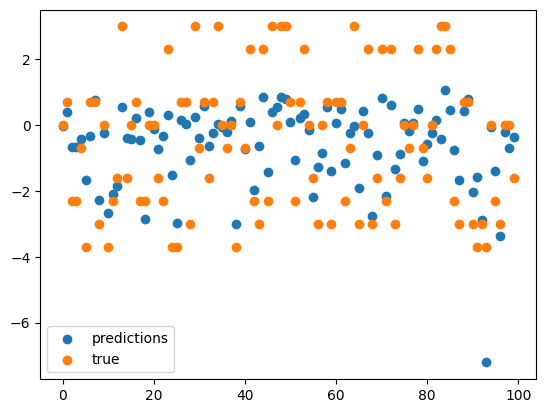

In [68]:
plt.scatter(range(100), predictions.flatten()[:100],label='predictions')
plt.scatter(range(100), y_true.flatten()[:100],label='true')
plt.legend()

In [59]:
y_true

tensor([[-2.3026],
        [ 2.3026],
        [-2.3026],
        [-2.3026],
        [ 2.9957],
        [ 2.3026],
        [ 0.6931],
        [ 2.3026],
        [ 0.0000],
        [ 0.6931],
        [-3.6889],
        [ 0.6931],
        [-2.9957],
        [-2.3026],
        [-2.3026],
        [-3.6889],
        [ 0.6931],
        [-0.6931],
        [ 0.0000],
        [ 2.3026],
        [-1.6094],
        [-2.3026],
        [-0.6931],
        [-3.6889],
        [-2.9957],
        [ 2.9957],
        [-2.9957],
        [ 2.3026],
        [ 0.0000],
        [ 2.9957],
        [-2.3026],
        [-3.6889],
        [-1.6094],
        [ 2.3026],
        [-2.9957],
        [-1.6094],
        [-3.6889],
        [ 0.6931],
        [ 2.3026],
        [-2.3026],
        [ 0.6931],
        [-1.6094],
        [-2.3026],
        [ 0.6931],
        [ 2.3026],
        [-0.6931],
        [-2.9957],
        [ 2.9957],
        [-0.6931],
        [-1.6094],
        [ 2.3026],
        [ 0.6931],
        [ 0.

In [24]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    y_test = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            data, label = data.to(device), data.y.to(device)
            output = model(data)

            # Calculate loss
            loss = F.mse_loss(output, label)
            test_loss += loss.item() * data.size(0)
            
            
            # Store the scores
            y_scores.extend(output.cpu().numpy().tolist())

            # Get predictions
            _, predicted = output.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

    avg_loss = test_loss / total
    accuracy = 100 * correct / total

    print(f"Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)")

    return avg_loss, accuracy, y_test, y_scores

# Assuming you have a test_loader, model, and criterion already defined
test_loss, test_accuracy, y_test, y_score = test(model, testloader)

Test set: Average loss: 179359.0595, Accuracy: 0/540 (0.00%)


In [25]:
from sklearn.metrics import roc_curve, auc
n_classes = 4
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
labels = {0:r'NS: $r > 5$',1:r'MS: $r \in [0.5,5]$',2:r'ES: $r \in (0.5,0.1]$',3:r'IS: $r<0.1$'}

In [ ]:
## try linear regression 
## try without the graph structure